In [1]:
from textblob import TextBlob
import re
from nltk import word_tokenize 
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [3]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he shall have he will have",
"he's": "he has he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has how is",
"i'd": "I had I would",
"i'd've": "I would have",
"i'll": "I shall I will",
"i'll've": "I shall have I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had it would",
"it'd've": "it would have",
"it'll": "it shall it will",
"it'll've": "it shall have it will have",
"it's": "it has it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had she would",
"she'd've": "she would have",
"she'll": "she shall she will",
"she'll've": "she shall have she will have",
"she's": "she has she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as so is",
"that'd": "that would that had",
"that'd've": "that would have",
"that's": "that has that is",
"there'd": "there had there would",
"there'd've": "there would have",
"there's": "there has there is",
"they'd": "they had they would",
"they'd've": "they would have",
"they'll": "they shall they will",
"they'll've": "they shall have they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has what is",
"what've": "what have",
"when's": "when has when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has where is",
"where've": "where have",
"who'll": "who shall who will",
"who'll've": "who shall have who will have",
"who's": "who has who is",
"who've": "who have",
"why's": "why has why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had you would",
"you'd've": "you would have",
"you'll": "you shall you will",
"you'll've": "you shall have you will have",
"you're": "you are",
"you've": "you have"
}

In [4]:
sentiment_category = {
    'Satisfaction' : ['like', 'love', 'enjoy', 'appreciate'], # like - nejednoznacne 
    'Dissatisfaction' : ['hate', 'dislike'],
    'Confusion' : ['confuse', 'stuck', 'puzzle'],
    'Expectation' : ['expect', 'hope', 'anticipate', 'assume', 'suppose'], # think but... hope to find ... look for
    'Suggestion' : ['prefer', 'preferable', 'favor', 'suggest'] # 'like better', 'go for'
}

In [5]:
with open("speech/2.txt", 'r') as transcript_sentences:
    text = transcript_sentences.read()

sentences = nltk.tokenize.sent_tokenize(text)

print(sentences)

for sentence in sentences:
    print(sentence)

['OK, so task number one.', 'Spend 1-2 minutes familiarizing.', 'Yourself with the website.', 'OK.', 'So there is no.', 'Uhm?', 'Tabs.', "So it's just for local, apparently.", 'Uhm?', 'OK so quicklinks.', 'Sounds like just so this makes me think about a file, but.', "Yeah OK, it's a file PDF.", "So I don't think there is any menu or something.", 'It looks like.', 'It could be not the the home page, I think.', 'But I guess it is.', 'And.', "OK, I'm not going to read this.", 'Not nice.', "I see what's the purpose I guess.", 'Few statistics here.', "I don't know if I should click elsewhere because all of these buttons seem like they are going to open something else and just another page.", "So I don't really want to open them.", 'Maybe this one seems safe.', 'I mean safe as in opening just another page.', "OK, that's another page.", 'Then we can type things.', "To search, I don't know what we can look for.", 'Right?', 'Visual impression with the website.', 'Uhm?', 'Yeah yeah.', "So apart 

In [6]:
def clean_sentences(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub(r'[^\w\s]', '', text)
    return text

lines_clean = []
for sentence in sentences:
    lines_clean.append(clean_sentences(sentence))
    
print(lines_clean)

['OK so task number one', 'Spend 12 minutes familiarizing', 'Yourself with the website', 'OK', 'So there is no', 'Uhm', 'Tabs', 'So it has it is just for local apparently', 'Uhm', 'OK so quicklinks', 'Sounds like just so this makes me think about a file but', 'Yeah OK it has it is a file PDF', 'So I do not think there is any menu or something', 'It looks like', 'It could be not the the home page I think', 'But I guess it is', 'And', 'OK I am not going to read this', 'Not nice', 'I see what has what is the purpose I guess', 'Few statistics here', 'I do not know if I should click elsewhere because all of these buttons seem like they are going to open something else and just another page', 'So I do not really want to open them', 'Maybe this one seems safe', 'I mean safe as in opening just another page', 'OK that has that is another page', 'Then we can type things', 'To search I do not know what we can look for', 'Right', 'Visual impression with the website', 'Uhm', 'Yeah yeah', 'So apart 

In [7]:
pos_dict = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(str(text)))
    newlist = []
    for word, tag in tags:
        newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

In [8]:
lines_token_pos = []
for sentence in lines_clean:
    lines_token_pos.append(token_stop_pos(sentence))

print(lines_token_pos)

[[('OK', 'n'), ('so', 'r'), ('task', 'a'), ('number', 'n'), ('one', None)], [('Spend', 'v'), ('12', None), ('minutes', 'n'), ('familiarizing', 'v')], [('Yourself', None), ('with', None), ('the', None), ('website', 'n')], [('OK', 'n')], [('So', 'r'), ('there', None), ('is', 'v'), ('no', None)], [('Uhm', 'n')], [('Tabs', 'n')], [('So', None), ('it', None), ('has', 'v'), ('it', None), ('is', 'v'), ('just', 'r'), ('for', None), ('local', 'a'), ('apparently', 'r')], [('Uhm', 'n')], [('OK', 'n'), ('so', 'r'), ('quicklinks', 'r')], [('Sounds', 'n'), ('like', 'a'), ('just', 'r'), ('so', 'r'), ('this', None), ('makes', 'v'), ('me', None), ('think', 'v'), ('about', None), ('a', None), ('file', 'n'), ('but', None)], [('Yeah', None), ('OK', 'n'), ('it', None), ('has', 'v'), ('it', None), ('is', 'v'), ('a', None), ('file', 'n'), ('PDF', 'n')], [('So', 'r'), ('I', None), ('do', 'v'), ('not', 'r'), ('think', 'v'), ('there', None), ('is', 'v'), ('any', None), ('menu', 'n'), ('or', None), ('something',

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()     

In [10]:
def lemmatize_(text):
    lemmatized_sentence = []
    for word, tag in text:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(wordnet_lemmatizer.lemmatize(word, tag))
    #lemmatized_sentence = " ".join(lemmatized_sentence)
    
    return lemmatized_sentence

In [11]:
lines_lemma = []
for phrase in lines_token_pos:
    lines_lemma.append(lemmatize_(phrase))

print(lines_lemma)

[['OK', 'so', 'task', 'number', 'one'], ['Spend', '12', 'minute', 'familiarize'], ['Yourself', 'with', 'the', 'website'], ['OK'], ['So', 'there', 'be', 'no'], ['Uhm'], ['Tabs'], ['So', 'it', 'have', 'it', 'be', 'just', 'for', 'local', 'apparently'], ['Uhm'], ['OK', 'so', 'quicklinks'], ['Sounds', 'like', 'just', 'so', 'this', 'make', 'me', 'think', 'about', 'a', 'file', 'but'], ['Yeah', 'OK', 'it', 'have', 'it', 'be', 'a', 'file', 'PDF'], ['So', 'I', 'do', 'not', 'think', 'there', 'be', 'any', 'menu', 'or', 'something'], ['It', 'look', 'like'], ['It', 'could', 'be', 'not', 'the', 'the', 'home', 'page', 'I', 'think'], ['But', 'I', 'guess', 'it', 'be'], ['And'], ['OK', 'I', 'be', 'not', 'go', 'to', 'read', 'this'], ['Not', 'nice'], ['I', 'see', 'what', 'have', 'what', 'be', 'the', 'purpose', 'I', 'guess'], ['Few', 'statistic', 'here'], ['I', 'do', 'not', 'know', 'if', 'I', 'should', 'click', 'elsewhere', 'because', 'all', 'of', 'these', 'button', 'seem', 'like', 'they', 'be', 'go', 'to',

In [12]:
stopwords_list = stopwords.words('english')

In [13]:
unwanted = {'no', 'not', 'nor'}
custom_stopwords = [e for e in stopwords_list if e not in unwanted]

In [14]:
def remove_stopwords(text):
    clean_text = []
    for word in text:
        if word.lower() not in set(custom_stopwords):
            clean_text.append(word.lower())
    return clean_text

In [15]:
preprocessed_text = []
for phrase in lines_lemma:
    preprocessed_text.append(remove_stopwords(phrase))

print(preprocessed_text)

[['ok', 'task', 'number', 'one'], ['spend', '12', 'minute', 'familiarize'], ['website'], ['ok'], ['no'], ['uhm'], ['tabs'], ['local', 'apparently'], ['uhm'], ['ok', 'quicklinks'], ['sounds', 'like', 'make', 'think', 'file'], ['yeah', 'ok', 'file', 'pdf'], ['not', 'think', 'menu', 'something'], ['look', 'like'], ['could', 'not', 'home', 'page', 'think'], ['guess'], [], ['ok', 'not', 'go', 'read'], ['not', 'nice'], ['see', 'purpose', 'guess'], ['statistic'], ['not', 'know', 'click', 'elsewhere', 'button', 'seem', 'like', 'go', 'open', 'something', 'else', 'another', 'page'], ['not', 'really', 'want', 'open'], ['maybe', 'one', 'seem', 'safe'], ['mean', 'safe', 'opening', 'another', 'page'], ['ok', 'another', 'page'], ['type', 'thing'], ['search', 'not', 'know', 'look'], ['right'], ['visual', 'impression', 'website'], ['uhm'], ['yeah', 'yeah'], ['apart', 'thing', 'use', 'sort', 'tab', 'top', 'navigate'], ['feel', 'like', 'bit', 'crowded'], ['information', 'look', 'guess'], [], ['uhm', 'not

In [16]:
analyzer = SentimentIntensityAnalyzer()

In [17]:
new_words = {
    'see': 2.0,
    'find': 2.0,
    'spot': 2.0,
    'grasp': 2.0,
    'perceive': 2.0,
    'identify': 2.0,
    'notice': 2.0,
    'distinguish': 2.0,
    'sight': 2.0,
    'glimpse': 2.0,
    'recognize': 2.0,
    'follow': 2.0,
    'realize': 2.0,
    'discover': 2.0,
    'little': -2.0,
    'small': -2.0,
    'tiny': -2.0,
    'large': 2.0,
    'know': 2.0, 
    'udnerstand': 2.0
}

analyzer.lexicon.update(new_words)

In [18]:
def search(values, searchFor):
    cat_list = []
    for word in searchFor:
        for k in values:
            for v in values[k]:
                if word == v:
                    cat_list.append(k)
                    #return k
    if cat_list:
        return cat_list
    return None

In [19]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [20]:
for sentence, line in zip(sentences, preprocessed_text):
    line_string = " ".join(line)
    txtblob_object = TextBlob(line_string)
    subjectivity = txtblob_object.sentiment.subjectivity
    sentiment_vader = analyzer.polarity_scores(line_string)

    sent_cat = search(sentiment_category, line)
    
    if sentiment_vader['compound'] < 0:
        polarity = 'Negative'
        neg_words_str_vader += line_string
        
    elif sentiment_vader['compound'] > 0:
        polarity = 'Positive'
        pos_words_str_vader += line_string
    else:
        polarity = 'Neutral'
    df_azure_speech = df_azure_speech.append({'Sentence': sentence,'Pre-processed sentence': line_string, 'textblob-subjectivity': subjectivity, 'vader-pos': sentiment_vader['pos'], 'vader-neg': sentiment_vader['neg'], 'vader-neu':sentiment_vader['neu'], 'vader-compound':sentiment_vader['compound'], 'vader-polarity': polarity, 'sentiment-category': sent_cat}, ignore_index=True)
  

In [21]:
df_azure_speech.to_csv("results/2-results.csv")

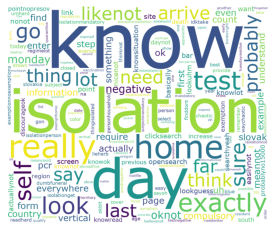

In [22]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(neg_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

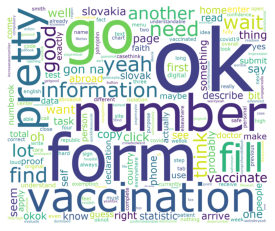

In [23]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(pos_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [24]:
# def sentiment_analysis(textfile):
#     with open(textfile) as transcript:
#         lines = transcript.readlines()
#     lines_clean = clean(lines[0])
#     lines_token_stop_pos = token_stop_pos(lines_clean)
#     lines_lemma = lemmatize(lines_token_stop_pos).lower()
#     ngram_object = TextBlob(lines_lemma)
#     ngrams = ngram_object.ngrams(n=3) 
#     for ngram in ngrams:
#         ngram_str = TextBlob(' '.join(ngram))
#         sentiment = ngram_str.sentiment.polarity
#         subjectivity = ngram_str.sentiment.subjectivity
#         # sentiment_vader = analyzer.polarity_scores(ngram_str)
#         if sentiment >= 0.2:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
#         if sentiment < 0:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
    
# #     file_content=open (textfile).read()

# #     wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
# #                             stopwords = STOPWORDS,
# #                             background_color = 'white',
# #                             width = 1200,
# #                             height = 1000,
# #                             color_func = random_color_func
# #                             ).generate(lines_lemma)
# #     plt.imshow(wordcloud)
# #     plt.axis('off')
# #     plt.show()

In [25]:
# sentiment_analysis("testing_text.txt")

In [26]:
df_azure_speech

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
0,"OK, so task number one.",ok task number one,0.500000,0.636,0.0,0.364,0.3612,Positive,None
1,Spend 1-2 minutes familiarizing.,spend 12 minute familiarize,0.000000,0.000,0.0,1.000,0.0000,Neutral,None
2,Yourself with the website.,website,0.000000,0.000,0.0,1.000,0.0000,Neutral,None
3,OK.,ok,0.500000,1.000,0.0,0.000,0.2960,Positive,None
4,So there is no.,no,0.000000,0.000,1.0,0.000,-0.2960,Negative,None
...,...,...,...,...,...,...,...,...,...
870,Uhm?,uhm,0.000000,0.000,0.0,1.000,0.0000,Neutral,None
871,"Yeah, three OK 33 seems good enough.",yeah three ok 33 seem good enough,0.533333,0.646,0.0,0.354,0.7430,Positive,None
872,OK.,ok,0.500000,1.000,0.0,0.000,0.2960,Positive,None
873,Thank you for you for participating.,thank participate,0.000000,0.714,0.0,0.286,0.3612,Positive,None


array([[<AxesSubplot:title={'center':'textblob-subjectivity'}>,
        <AxesSubplot:title={'center':'vader-pos'}>],
       [<AxesSubplot:title={'center':'vader-neg'}>,
        <AxesSubplot:title={'center':'vader-neu'}>],
       [<AxesSubplot:title={'center':'vader-compound'}>, <AxesSubplot:>]],
      dtype=object)

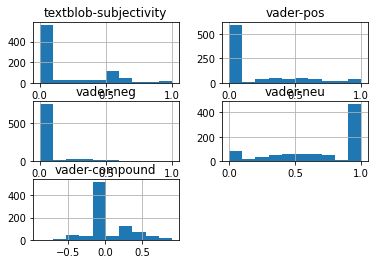

In [27]:
df_azure_speech.hist()

<AxesSubplot:xlabel='vader-polarity', ylabel='vader-compound'>

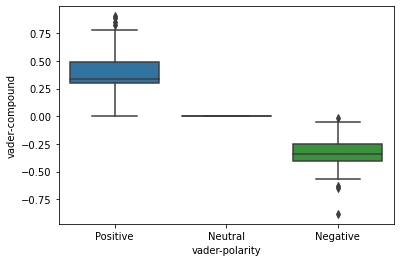

In [28]:
sns.boxplot(data=df_azure_speech, x="vader-polarity", y="vader-compound")

<AxesSubplot:ylabel='vader-polarity'>

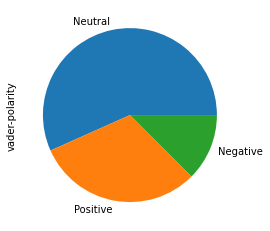

In [29]:
df_azure_speech['vader-polarity'].value_counts().plot(kind='pie')

In [30]:
df_azure_speech.sort_values('vader-compound').head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
431,Home isolation home isolation ends up through ...,home isolation home isolation end negative pcr...,0.350000,0.0,0.507,0.493,-0.8834,Negative,None
192,Not sure it was the best way.,not sure best way,0.594444,0.0,0.727,0.273,-0.6520,Negative,None
147,So we we haven't even arrived to home isolatio...,not even arrive home isolation arrive slovakia...,0.000000,0.0,0.365,0.635,-0.6346,Negative,None
287,A negative test.,negative test,0.400000,0.0,0.787,0.213,-0.5719,Negative,None
415,Strict negative test is not enough to enter th...,strict negative test not enough enter country ...,0.411111,0.0,0.270,0.730,-0.5719,Negative,None
215,Where you if you are coming from another count...,come another country one list need show negati...,0.400000,0.0,0.316,0.684,-0.5719,Negative,None
672,So I should be able to click on something call...,able click something call nimni po,0.625000,0.0,0.419,0.581,-0.5574,Negative,None
848,And it's mostly because of the time you spend ...,mostly time spend search information not exact...,0.694444,0.0,0.357,0.643,-0.5334,Negative,None
208,"So Oh no, I thought I thought it was going to ...",oh no think think go form no,0.000000,0.0,0.468,0.532,-0.5267,Negative,None
259,With a proof of vaccination and no COVID like ...,proof vaccination no covid like symptom not need,0.000000,0.0,0.418,0.582,-0.5122,Negative,[Satisfaction]


In [31]:
df_azure_speech.sort_values('vader-compound', ascending=False).head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
733,"OK. Obviously I'm not gonna read this, but it ...",ok obviously not gon na read look like see see...,0.500000,0.623,0.000,0.377,0.9042,Positive,"[Satisfaction, Satisfaction]"
559,So download information chart in good faith de...,download information chart good faith declarat...,0.600000,0.655,0.000,0.345,0.8860,Positive,None
528,"No, I'd say overall pretty OK, pretty good.",no would say overall pretty ok pretty good,0.620000,0.689,0.132,0.180,0.8519,Positive,None
825,"It hits your eyes pretty nicely, so I like this.",hit eye pretty nicely like,1.000000,0.811,0.000,0.189,0.8225,Positive,[Satisfaction]
488,"OK, OK OK OK next task.",ok ok ok ok next task,0.400000,0.815,0.000,0.185,0.7783,Positive,None
189,Straight up finding this page was pretty hard.,straight find page pretty hard,0.647222,0.771,0.133,0.095,0.7717,Positive,None
327,"I was already on the right page, so it was pre...",already right page pretty ok yeah would say fa...,0.678571,0.521,0.000,0.479,0.7650,Positive,None
149,"I'm gonna try this OK. OK, so we need to find ...",gon na try ok ok need find exemption,0.500000,0.597,0.000,0.403,0.7506,Positive,None
534,"It's wait, oh OK yeah you can see them here.",wait oh ok yeah see,0.500000,0.787,0.000,0.213,0.7506,Positive,None
479,APR OK I'm Or you guys are doing great with my...,apr ok guy great data,0.625000,0.677,0.000,0.323,0.7430,Positive,None
